In [4]:
import numpy as np

import synpivimage as spi 
spi.__version__

from pprint import pprint
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt

In [5]:
def plot_img(img, ax, **kwargs):
    im = ax.imshow(img, cmap='gray', **kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cb = plt.colorbar(im, cax=cax)

In [150]:
laser = spi.Laser(shape_factor=10**3, width=10)

cam = spi.Camera(
    nx=128,
    ny=128,
    bit_depth=16,
    qe=1,
    sensitivity=1,
    baseline_noise=0,
    dark_noise=0,
    shot_noise=False,
    fill_ratio_x=1.0,
    fill_ratio_y=1.0,
    particle_image_diameter=2,
    seed=10
)

ppp = 0.1
x_margin = 10, 0
y_margin = 10, 0
z_margin = 2, 0

FOVx = cam.nx + x_margin[0] + x_margin[1]
FOVy = cam.ny + y_margin[0] + y_margin[1]
FOVz = laser.width + z_margin[0] + z_margin[1]

print(FOVx)
print(FOVy)
print(FOVz)
n_particles = int(ppp*FOVx*FOVy*FOVz)
print(n_particles)
N =  int(n_particles/2/2/2)
print(N)
px = np.random.uniform(-x_margin[0], cam.nx+x_margin[1], N)
py = np.random.uniform(-y_margin[0], cam.ny+y_margin[1], N)
pz = np.random.uniform(-laser.width/2-z_margin[0], laser.width/2+z_margin[1], N)

particles = spi.Particles(
    x=px,
    y=py,
    z=np.zeros_like(px),
    size=np.ones_like(px)*2
)

138
138
12.0
22852
2856


In [151]:
imgA, partA = spi.take_image(particles=particles,
                             cam=cam,
                             laser=laser,
                             particle_peak_count=1000)

In [152]:
partA.in_fov.sum()/cam.nx/cam.ny

0.14599609375

In [153]:
partB = partA.displace(dx=5, dy=10, dz=0.1)

In [154]:
imgB, partB = spi.take_image(particles=partB,
                            cam=cam, laser=laser,
                             particle_peak_count=1000)

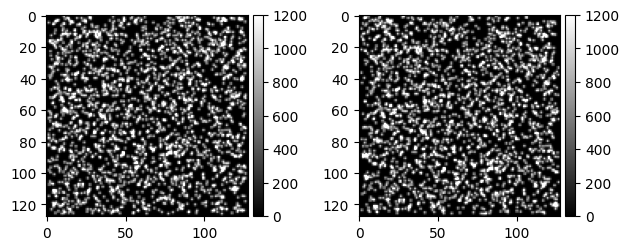

In [155]:
fig, axs = plt.subplots(1, 2)
plot_img(imgA, axs[0], vmax=1200)
plot_img(imgB, axs[1], vmax=1200)
plt.tight_layout()
plt.show()

In [ ]:
from synpivimage import velocityfield

out_of_plane_fraction = 0.5
cfield = velocityfield.ConstantField(dx=0.3, dy=1.6, dz=out_of_plane_fraction*cfg.laser_width)
displaced_particle_data = cfield.displace(cfg=cfg, part_info=partA)

In [ ]:
imgB, _, partB = spi.generate_image(
    cfg,
    particle_data=displaced_particle_data
)

In [ ]:
# partB.size

In [ ]:
fig, axs = plt.subplots(1, 2)
plot_img(imgA, axs[0], vmax=2**cfg.bit_depth)
plot_img(imgB, axs[1], vmax=2**cfg.bit_depth)
plt.tight_layout()
plt.show()

# Out of plane effect - zoom to an interrogation window

Let's investigate a few particles, e.g. 6, inside an IA:

In [ ]:
cfg.particle_number = 6
cfg.nx = 16
cfg.ny = 16
cfg.particle_size_mean = 2.5
cfg.particle_size_std = 0
cfg.laser_width = 1
cfg.particle_density()

In [ ]:
xtrue = 0.6
ytrue = 0.3

imgsA = []
imgsB = []

out_of_plane_fraction = 0.0

for _ in range(100):
    imgA, _, partA = spi.generate_image(
        cfg
    )

    cfield = velocityfield.ConstantField(dx=0.3, dy=1.6, dz=out_of_plane_fraction*cfg.laser_width)
    displaced_particle_data = cfield.displace(cfg=cfg, part_info=partA)
    
    imgB, _, partB = spi.generate_image(
        cfg,
        particle_data=displaced_particle_data
    )
    imgsA.append(imgA)
    imgsB.append(imgB)

import numpy as np

imgsA = np.stack(imgsA, 0)
imgsB = np.stack(imgsB, 0)

In [ ]:
fig, axs = plt.subplots(1, 2)
plot_img(imgsA[3, ...], axs[0], vmax=2**cfg.bit_depth)
plot_img(imgsB[3, ...], axs[1], vmax=2**cfg.bit_depth)
plt.tight_layout()
plt.show()

In [ ]:
from scipy.fft import rfft2, irfft2, fftshift
import numpy as np

In [ ]:
def get_corr_plane(imgA, imgB):
    f2a = np.conj(rfft2(imgA))
    f2b = rfft2(imgB)
    corr = fftshift(irfft2(f2a * f2b).real, axes=(-2, -1))
    return corr

def get_integer_peak(corr):
    ind = corr.ravel().argmax(-1)
    peaks = np.array(np.unravel_index(ind, corr.shape[-2:]))

    peaks = np.vstack((peaks[0], peaks[1])).T
    index_list = [(i, v[0], v[1]) for i, v in enumerate(peaks)]
    peaks_max = np.nanmax(corr, axis = (-2, -1))

    # np.array(index_list), np.array(peaks_max)
    iy, ix = index_list[0][2], index_list[0][1]
    return iy, ix

def get_sub_peak_position(_corr):
    eps =1e-7
    corr = _corr + eps
    subp_peak_position = (np.nan, np.nan)
    peak1_i = peak1_indexndex[1]
    peak1_j = peak1_indexndex[2]

    c = corr[peak1_i, peak1_j]
    cl = corr[peak1_i - 1, peak1_j]
    cr = corr[peak1_i + 1, peak1_j]
    cd = corr[peak1_i, peak1_j - 1]
    cu = corr[peak1_i, peak1_j + 1]

    nom1 = np.log(cl) - np.log(cr)
    den1 = 2 * np.log(cl) - 4 * np.log(c) + 2 * np.log(cr)
    nom2 = np.log(cd) - np.log(cu)
    den2 = 2 * np.log(cd) - 4 * np.log(c) + 2 * np.log(cu)
    
    subp_peak_position = (
        peak1_i + np.divide(nom1, den1, out=np.zeros(1),
                            where=(den1 != 0.0))[0],
        peak1_j + np.divide(nom2, den2, out=np.zeros(1),
                            where=(den2 != 0.0))[0],
    )
    return subp_peak_position

In [ ]:
corr = get_corr_plane(imgsA[0], imgsB[0])
iyINT, ixINT = get_integer_peak(corr)

In [ ]:
plt.imshow(corr, cmap='gray')
plt.scatter(iyINT, ixINT, marker='+', label='max in value')
plt.legend()

Determination of subpixel peak location (gaussian)

In [ ]:
def gauss(x, x0, k, C):
    return C*np.exp((-(x0-x)**2)/k)

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
def plot_subpeak(R3, peak_loc, ax=None, color=None):
    """R3 = R[-1], R[0], R[1]"""
    if ax is None:
        ax = plt.gca()
    popt, pcov = curve_fit(gauss, [-1, 0, 1], R3)
    ax.scatter([-1, 0, 1], R3, color=color)
    _x = np.linspace(-2, 2, 101)
    g = gauss(_x, *popt)
    ax.plot(_x, g, color=color)
    ax.scatter(peak_loc, g.max(), marker='x', color=color)
    return ax

In [ ]:
fig, axs = plt.subplots(1, 2)
plot_img(corr, axs[0])
# axs[0].scatter(peak1_i, peak1_j,
#                marker='+', label='max in value')
# axs[1].plot([-1,0,1], [cl, c, cr], 'b--')
# axs[1].plot([-1,0,1], [cd, c, cu], 'r--')
axs[0].scatter([peak1_j-1, peak1_j, peak1_j+1],
               [peak1_i, peak1_i, peak1_i],
               color='r', marker='.')
axs[0].scatter([peak1_j, peak1_j, peak1_j],
               [peak1_i-1, peak1_i, peak1_i+1],
              color='b', marker='.')
axs[0].scatter(subp_peak_position[1], subp_peak_position[0],
              color='g', marker='+')

c = corr[peak1_i, peak1_j]
cl = corr[peak1_i - 1, peak1_j]
cr = corr[peak1_i + 1, peak1_j]
cd = corr[peak1_i, peak1_j - 1]
cu = corr[peak1_i, peak1_j + 1]

ipeak, jpeak = get_sub_peak_position(corr)

plot_subpeak([cl, c, cr], peak_loc=ipeak-cfg.nx/2, ax=axs[1], color='r')
plot_subpeak([cd, c, cu], peak_loc=jpeak-cfg.ny/2, ax=axs[1], color='b')
asp = np.diff(axs[1].get_xlim())[0] / np.diff(axs[1].get_ylim())[0]
axs[1].set_aspect(asp)

plt.tight_layout()

dy = subp_peak_position[0] - cfg.ny/2
dx = subp_peak_position[1] - cfg.nx/2
print(f'displacement: dy={dy:.2f}, nx={dx:.2f}')
dx_err = np.abs(dx-xtrue)
dy_err = np.abs(dy-ytrue)
print(f'x err: {dx_err:.3f}, y err: {dy_err:.3f}')

n_imgs = imgsA.shape[0]

dxs, dys = [], []
for i in range(n_imgs):
    _corr = get_corr_plane(imgsA[i, ...], imgsB[i, ...])
    subp_peak_position = get_sub_peak_position(_corr)
    dys.append(subp_peak_position[0] - cfg.ny/2)
    dxs.append(subp_peak_position[1] - cfg.nx/2)


binwidth = 0.05
plt.figure()
bins = np.arange(np.nanmin(dxs), np.nanmax(dxs) + binwidth, binwidth)
plt.hist(dxs, density=True, bins=bins)

bins = np.arange(np.nanmin(dys), np.nanmax(dys) + binwidth, binwidth)
plt.hist(dys, density=True, bins=bins)
plt.vlines(xtrue, 0, 10)
plt.vlines(ytrue, 0, 10)
plt.xlim(0, 1)
plt.show()